# Exploration of Short Term Rental Data for Newport, RI
This notebook explores a few datasets related to short-term rentals in the City of Newport, RI, with the goal of better understanding the ability of the City to regulate this new business model and to examine the impacts on the residents of the city.

The first dataset is a collection of AirBnB listings in Rhode Island collected from the website.  These data represent a snapshot of the actual properties being rented on the platform.

The second dataset is the registration information that transient guest facility (including short-term rentals) operators are required to register with the city.  These data represent information reported by owners, and does not account for owners operating outside the regulatory framework within the city.

These datasets are best-available data.  Some caveats are noted herein, but there are likely unidentified factors that influence the data which haven't been accounted for.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import folium
from folium import plugins

## Rhode Island AirBnB Listings in July 2021
This dataset was collected from publicly facing data from the AirBnB service in July 2021.

In [2]:
abb_raw = pd.read_excel('Raw Data AirBNB 7_23_2021.xlsx', dtype={'room_type':'category'})
abb_raw.drop(labels=['host_name'], axis=1, inplace=True)
geom = [Point(xy) for xy in zip(abb_raw.longitude, abb_raw.latitude)]
abb_data = gpd.GeoDataFrame(abb_raw, crs='epsg:4326', geometry=geom)

In [3]:
abb_data.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry
0,10262,Secluded 1750's home on 46 acres,35244,Providence,Glocester,41.86617,-71.72344,Private room,65,1,37,2017-08-31,0.44,1,0,POINT (-71.72344 41.86617)
1,15373,Adorable Beach Cottage Scarborough Beach RI,60209,Washington,Narragansett,41.39375,-71.47447,Entire home/apt,100,7,3,2020-08-28,0.35,1,6,POINT (-71.47447 41.39375)
2,50817,Sanctuary in the Suburbs,233965,Providence,Pawtucket,41.88613,-71.35373,Entire home/apt,76,2,148,2021-01-31,1.16,1,280,POINT (-71.35373 41.88613)
3,51583,Bedroom In a large Victorian Home,237379,Providence,Providence,41.81244,-71.42076,Private room,58,1,372,2020-08-03,2.93,8,89,POINT (-71.42076 41.81244)
4,55464,Waterfront Narrow River Spring/summer kayaks c...,262000,Washington,South Kingstown,41.46965,-71.44939,Entire home/apt,295,7,88,2019-12-15,0.83,1,281,POINT (-71.44939 41.46965)


### Density of AirBnB in RI

In [4]:
map = folium.Map(location=[41.6, -71.5], tiles='Stamen toner', zoom_start=9)
heat_data = [[point.xy[1][0], point.xy[0][0]] for point in abb_data.geometry]
plugins.HeatMap(heat_data).add_to(map)
map

Newport is the main tourist attraction in Rhode Island, so it would be interesting to see how many of the AirBnBs listed in the state are in Newport.

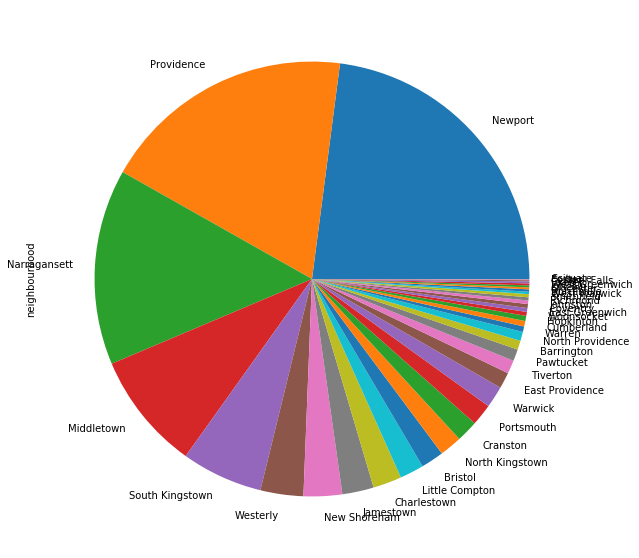

In [84]:
city_listing_count = abb_data['neighbourhood'].value_counts()
city_listing_count.plot.pie(figsize=[10,10])
plt.show()

In [6]:
# calculate the percentage of RI airbnbs in newport
city_listing_count['Newport'] / city_listing_count.sum()

0.22939801285797778

That's 23% of the listings, and the single largest market for listings beating out the largest city in the state.  The dataset also tells us what kinds of properties are listed.  Let's zoom in on Newport.

In [7]:
npt_abb = abb_data[abb_data['neighbourhood']=='Newport']
npt_abb['room_type'].value_counts()

Entire home/apt    579
Private room       170
Hotel room          32
Shared room          4
Name: room_type, dtype: int64

In [92]:
len(npt_abb)  # total listings in newport

785

The listings in Newport are predominantly entire homes or apartments; in other words, these are complete dwelling units that are being used for short term stays.  We haven't looked at how often these units are rented - some of these might be generating some extra cash for the residents when they vacation somewhere else!  Let's take a look. 

In [8]:
npt_abb.groupby(by='room_type')['availability_365'].describe()  # assumes availability_365 means number of days listed per year

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,579.0,151.411054,121.228674,0.0,28.50,137.0,268.50,365.0
Hotel room,32.0,172.750000,81.256265,0.0,104.75,190.0,221.50,365.0
Private room,170.0,135.388235,131.168945,0.0,9.25,87.0,239.75,365.0
Shared room,4.0,242.750000,167.663105,0.0,197.25,303.0,348.50,365.0


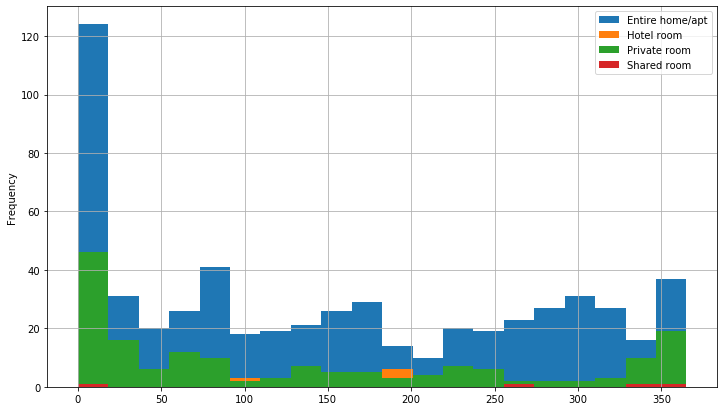

In [82]:
npt_abb.groupby(by='room_type')['availability_365'].plot.hist(bins=20, legend=True, figsize=[12,7], grid=True)
plt.show()

According to this dataset, 1/4 of the `entire home/apt` listings are available for less than one month in a year.  It also shows 1/4 of those listings are availablle 9 months out of the year.

## City of Newport Registered Transient Guest Facilities 2021
This data was provided by the City of Newport in 2021.

In [71]:
guest_facility_data = pd.read_excel('Copy of Transient Guest Facilities 2021.xlsx', dtype={'Zoning District':'category', 'Type of Property':'category'})
guest_facility_data.drop(labels=['Email', "Owner's phone #"], axis=1, inplace=True)  # censor contact information
guest_facility_data = guest_facility_data[1:]  # drop the test record at the start of the file

# clean data
guest_facility_data.replace(
    to_replace={'Mixed-Use':'Mixed Use', 
                'Comm. Condo': 'Comm Condo', 
                'Single':'Single Family', 
                'Singe Family': 'Single Family',
                'Three-Family': 'Three Family',
                'Condo': 'Res Condo',
                'Two-Family': 'Two Family',
                'Timeshare Condos': 'Timeshare',
                'Single family': 'Single Family',
                'Four Family': 'Multi Family',
                'Five Family': 'Multi Family',
                'Multi-Family': 'Multi Family',
                'No':'no'
               },
    inplace=True)

In [91]:
len(guest_facility_data)  # number of registration records

461

In Newport, transient guest facilities are allowed in business districts by right.  However, a concern is that these guest facilities are encroaching on resident housing in residential zones, which require special use permits.

In [13]:
guest_facility_data['Zoning District'].value_counts()

R10     172
GB      111
LB       52
WB       48
R10A     23
R3       19
R20      15
R120      8
CI        4
R60       3
R40       3
TM        1
G         1
Name: Zoning District, dtype: int64

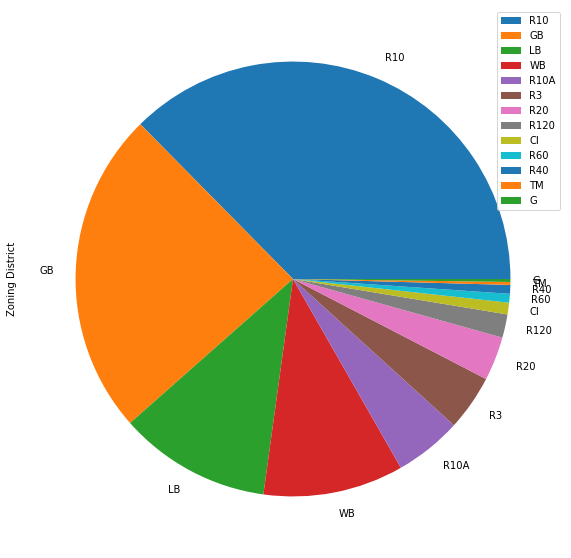

In [42]:
guest_facility_data['Zoning District'].value_counts().plot.pie(legend=True, figsize=[20,10])
plt.show()

The data show that many of the registered guest facilities are in fact on land designated for residential use by the city's zoning ordinances.  We can calculate that proportion:

In [49]:
guest_facility_data['Zoning District'].value_counts()[['R10', 'R10A', 'R3', 'R20', 'R120', 'R60', 'R40']].sum() / guest_facility_data['Zoning District'].value_counts().sum()

0.5282608695652173

That is over 50% of the registered properties operating in residential zones!  We can see where these zones are in the map of land parcels.

In [32]:
parcels = gpd.read_file('../Newport-Parcel/Newport_Parcels20171011.shp')  # parcel data provided by the city of newport in 2017.

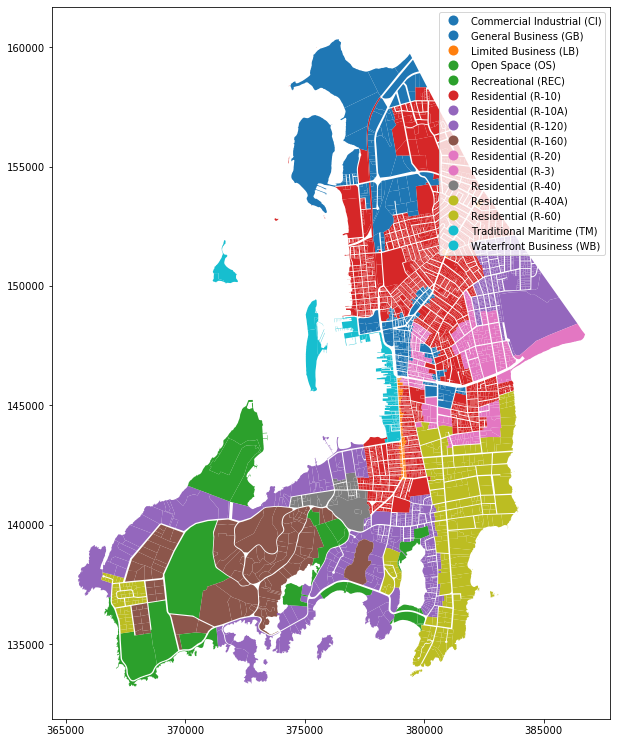

In [41]:
parcels.plot(column='Zone', legend=True, figsize=[10,15])
plt.show()

It is little surprise that R10 is well represented in the data.  R10 zones are situated within easy walking distance of many of active business districts that feature dining and nightlife.  R10 zones also have some of the more accessible housing stock, i.e. modestly sized single family homes with moderate density.  We can examine the data to see what types of property are listed.

In [51]:
guest_facility_data['Type of Property'].value_counts()

Single Family              147
Two Family                  83
B&B/Inn                     49
Mixed Use                   48
Res Condo                   26
Comm Condo                  19
Three Family                17
Stores/Apt Com              17
Hotel                       13
Large Bus                   11
Apartment                    8
Timeshare                    7
Multi Family                 7
Res Type Comm                3
Charitable                   1
Large Business- 4 Story      1
Estate                       1
Cottage                      1
Res2RmRent                   1
Name: Type of Property, dtype: int64

The dataset doesn't seem to have high quality data in this field.  There are possible overlaps among the categories, and they are not well defined.  Looking at how many rooms are available might also help understand the properties that are being rented.

In [60]:
guest_facility_data.groupby(by='Type of Property')[['Number of rooms']].describe()


Number of rooms                                     \
                                  count       mean         std   min   25%   
Type of Property                                                             
Apartment                           8.0   2.625000    1.060660   2.0   2.0   
B&B/Inn                            49.0   8.755102    5.265970   2.0   5.0   
Charitable                          1.0  10.000000         NaN  10.0  10.0   
Comm Condo                         19.0   9.842105   14.829637   2.0   3.0   
Cottage                             1.0   1.000000         NaN   1.0   1.0   
Estate                              1.0   2.000000         NaN   2.0   2.0   
Hotel                              13.0  88.461538  107.692940   2.0  10.0   
Large Bus                          11.0  49.909091   56.456097   2.0  15.0   
Large Business- 4 Story             1.0   6.000000         NaN   6.0   6.0   
Mixed Use                          48.0   3.062500    3.910739   1.0   1.0   
Multi Family                        7.0   3.571429    2.572751   1.0   2.0   
Res Condo                          26.0   2.269231    2.182800   1.0   1.0   
Res Type Comm                       3.0   2.000000    0.000000   2.0   2.0   
Res2RmRent                          1.0   2.000000         NaN   2.0   2.0   
Single Family                     147.0   2.108844    1.375566   1.0   1.0   
Stores/Apt Com                     17.0   2.764706    1.393261   1.0   2.0   
Three Family                       17.0   2.529412    1.374666   1.0   2.0   
Timeshare                           7.0  36.428571   32.572264  11.0  14.5   
Two Family                         83.0   2.108434    1.147766   1.0   1.5   

                                             
                          50%    75%    max  
Type of Property                             
Apartment                 2.0    3.0    5.0  
B&B/Inn                   7.0   12.0   23.0  
Charitable               10.0   10.0   10.0  
Comm Condo                3.0    9.0   58.0  
Cottage                   1.0    1.0    1.0  
Estate                    2.0    2.0    2.0  
Hotel                    33.0  133.0  320.0  
Large Bus                33.0   66.5  200.0  
Large Business- 4 Story   6.0    6.0    6.0  
Mixed Use                 2.0    4.0   28.0  
Multi Family              2.0    5.0    8.0  
Res Condo                 2.0    2.0   12.0  
Res Type Comm             2.0    2.0    2.0  
Res2RmRent                2.0    2.0    2.0  
Single Family             2.0    2.0   11.0  
Stores/Apt Com            3.0    4.0    5.0  
Three Family              2.0    3.0    5.0  
Timeshare                22.0   45.5  102.0  
Two Family                2.0    2.0    7.0

While it is difficult to draw conclusive insights from this particular analysis, it is apparent that many of the properties are renting only a few rooms, regardless of the category of the property.  We can look at this directly.

In [68]:
guest_facility_data[['Number of rooms']].describe()

,Number of rooms
count,461.000000
mean,7.436009
std,25.737866
min,1.000000
25%,2.000000
50%,2.000000
75%,4.000000
max,320.000000


The registered properties are overwhelmingly renting a few rooms.  Since the overall quality of the dataset is mediocre, it is not clear if these are rooms per unit, or units per property.  Likely, the responses include some mix of these interpretations.

We can also look at the owners of the property.  A property with a resident owner is more likely to be providing some amount of housing stock for Newport residents, however the definition is unclear at this point.  It is probably safe to assume that a property with no resident owner is not providing housing for Newport residents.

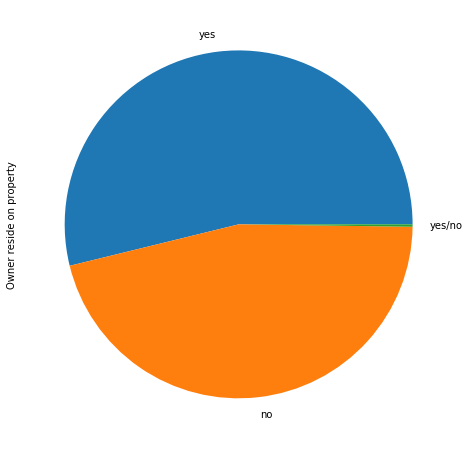

In [83]:
guest_facility_data['Owner reside on property'].value_counts().plot.pie(figsize=[8,8])
plt.show()

We can get also see how many owners are local (or at least have a locally registered business) compared with out of state owners.

In [77]:
guest_facility_data['State'].value_counts()

RI    397
MA     30
NY     11
CT      8
FL      3
NJ      3
OR      2
ME      1
PA      1
VA      1
CA      1
R       1
TX      1
MI      1
Name: State, dtype: int64

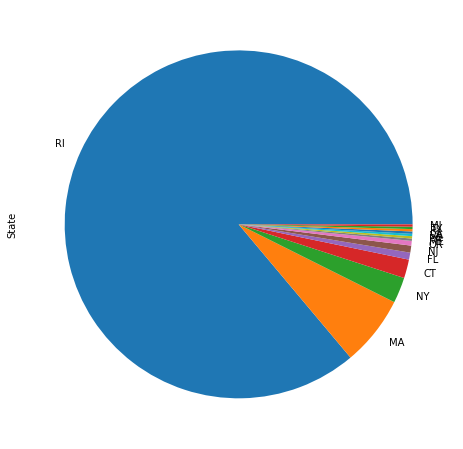

In [79]:
guest_facility_data['State'].value_counts().plot.pie(figsize=[8,8])
plt.show()

Most registered property owners have their business address in RI.  This result should be interpreted with caution; short term rental laws vary widely across the country, so it is much less likely that an out of state owner would know to register with the municipality in Newport.  This is further compounded by the lack of enforcement at the state level, and the practical challenges of enforcement at the local level.